In [1]:
import nlp
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

In [2]:
train_path = "D:/project/dataset/patent/b/data000000000001.json"

df = pd.read_json(train_path,lines=True)

df = df.rename(columns={"description": "input_text", "abstract": "target_text"})
df = df.dropna()
df.head()
# raw_data = nlp.load_dataset('cnn_dailymail', '3.0.0', split='train[:1%]')
# df = pd.DataFrame(raw_data)
# df.head()

,publication_number,target_text,application_number,input_text
0,US-2012211503-A1,"a medicinal vial protector and identifier system has a holding vessel , an interior cavity designed to hold a medicinal vial , an exterior sidewall that can be easily identified by a person , a plurality of retaining ribs designed to retain the vial within the holding vessel and facilitate insertion and removal of the vial , and at least one contents porthole to allow an easy determination of the amount of materials contained in the vial while the vial remains safely ensconced within the holding vessel . additionally , a bottom port can be incorporated which facilitates the easy removal of...",US-201213459068-A,"a medicinal vial protector and identifier system can comprise a single holding vessel or it can comprise two or more holding vessels , wherein the shapes of the outside perimeters of the sidewalls are different between the vessels . for example , a two - vessel system could have a first vessel that has a rounded , cylindrically shaped sidewall and a second vessel that has a four - sided , square shaped sidewall . the first vessel could then contain a first type of medicine and the second could contain a second type of medicine . a patient can then very easily tell the difference between th..."
1,US-2005199072-A1,"the present invention is directed to a method of sensing pressure in which applied pressure causes a change in the magnetization vector of a magnetoresistive layer within the device and a corresponding change in resistance . the method includes providing a sensing device with a sensor including plurality of layers , the plurality of layers comprising a non magnetic conducting layer disposed between a magnetoresistive layer with non - zero magnetostriction and a ferromagnetic biasing layer . once provided , the method then includes sensing a resistance in the plurality of layers upon applic...",US-12366005-A,"this invention uses a magnetoresistive element , to realize a pressure sensor with very high sensitivity while maintaining miniaturized dimensions . magnetoresistive materials and devices have been described in great detail elsewhere ( see , e . g . c . d . mee and e . d . daniel , “ magnetic recording , vol . 1 : technology ,” mcgraw - hill , new york , 1987 , pp . 244 - 336 ), and are extensively used in the field of magnetic recording , where the sensor is used to sense small changes in the magnetic field . the present invention exploits the properties of such materials in novel ways fo..."
2,US-9776810-B2,"the disclosed method , and corresponding system , for controlling items on a production / distribution line relies on secure identification of items transported arranged according a given disposition along a transport path at different sites of the line and checking operation according to a protocol which allows reducing processing load while ensuring high reliability .",US-201214360797-A,"in the following non - limiting and illustrative embodiment of the invention , a system for controlling packaging operations on items on a production / distribution line ( 2 ), as illustrated on fig1 , comprises a conveyor ( 3 ) for transporting items ( 1 , 2 , . . . , n , n + 1 , . . . ) arranged in single file along the transport path from a first zone ( 4 ) toward a second zone ( 5 ) on the line . each item is marked with a unique item identifier ( 6 ), here a barcode , which includes unique item identification data of the item . a controller ( 10 ) controls the operations on the line ...."
3,US-5522634-A,"a windshield visor which has a visor frame , a plurality of running lights formed on the visor frame , a translucent insert which fits within the visor frame , bonding member positioned between the translucent insert and the visor frame , and which preferably has the translucent visor insert in conforming relationship to the visor frame structure , and fitting wholly over all fastening means . in a preferred embodiment , the viso

In [3]:
pretrained_model_name = "facebook/bart-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.configuration_bart.BartConfig,
 transformers.tokenization_bart.BartTokenizer,
 transformers.modeling_bart.BartForConditionalGeneration)

In [4]:
hf_batch_tfm = HF_SummarizationBatchTransform(hf_arch, hf_tokenizer, max_length=[256, 130])

blocks = (HF_TextBlock(hf_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('input_text'), 
                   get_y=ColReader('target_text'), 
                   splitter=RandomSplitter())

In [5]:
dls = dblock.dataloaders(df, bs=8,num_workers=0)

In [6]:
len(dls.train.items), len(dls.valid.items)

(1124, 280)

In [7]:
dls.show_batch(dataloaders=dls)



,text,target
0,"referring to the drawings and particularly to fig1 a and 1b, several forms of the connector apparatus of the present invention for interconnecting guide rails in elevator systems with various types of structural components is there illustrated. in the area of fig1 a designated by the letter a, a connector apparatus for interconnecting the guide rails of a counterweight system with two pair of vertically extending columns is there illustrated. shown in the area designated by the letter b in fig1 b is a connector apparatus for interconnecting the guide rails of a counterweight system with one wall of the building structure that houses the elevator system. in the area of fig1 a designated by the letter c there is shown a connector apparatus for interconnecting a guide rail of an elevator system with one wall of the building structure that houses the elevator system. in the area designated by the letter d in fig1 a is a connector apparatus for interconnecting the guide rails of an elevator system with a pair of vertically extending columns. shown in the area designated by the letter e in fig1 b is a connector apparatus for interconnecting the guide rails of an elevator system with a horizontally extending beam, in the area designated by the letter f in fig1 b is another form of connector apparatus for","an apparatus for quickly, easily and adjustably connecting elevator car and counterweight guide rail support brackets to the walls of an elevator hoistway and also to either vertically or horizontally extend structural beams that are disposed within the elevator hoistway. installation of the apparatus requires no welding operations to be performed in order to connect the brackets to the walls or to the beams. the apparatus uniquely includes cooperating support and connector brackets each of which has a plurality of strategically arranged, indexable connector holes that permit the necessary degree of adjustment of the brackets to properly position the guide rails within the hoistway."
1,"referring first to fig1 a web ( in this example, paper ) handling system with which the present invention is concerned involves three parts. a first part, generally indicated at 1, takes paper from one or more paper rolls in the form of a web 2 and transports it to a printing unit 3 and an optional drying unit 4. as illustrated in fig1 a right - angled turn in the paper web 2 is achieved by passing the paper round an angled bar 5. after passing through the printing unit 3, and the drying unit 4, the paper web 2 is again turned for convenience through 90 ° via bar 6, and passed to a cutting and folding arrangement generally indicated at 7. sheets of paper printed, cut and folded as appropriate then pass for e. g. stacking in the direction indicated by the arrow 8. of course, any arrangement of paper web input unit 1, printing station 3, drying station 4, and cutting and folding arrangement 7 may be provided, the actual configuration depending on space and similar constraints. as discussed above, the present invention is concerned with various developments of the components of this system. fig2 shows one embodiment of a transport and feeding arrangement 1 for material ( e. g. paper ) on rolls. it consists of a splicing unit generally","a printing apparatus has an array of cartridges for printing a web of e. g. paper passing through the array, and one or more units containing printing medium. the cartridges each are capable of transferring the printing medium from the unit to the web. the unit and the cartridges of the array are relatively movable, to allow the unit to interact successively with at least two of the cartridges. in this way it is possible to change printing from one cartridge to another, allowing changes to be made to what is printed, without halting the movement of web significantly. the present invention also proposes that the cartridges may have printing cylinders of different sizes, and"


In [8]:
text_gen_kwargs = { **hf_config.task_specific_params['summarization'], **{'max_length': 130, 'min_length': 30} }
text_gen_kwargs

{'length_penalty': 1.0, 'max_length': 130, 'min_length': 30, 'num_beams': 4}

In [9]:
model = HF_BaseModelWrapper(hf_model)
model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=HF_MaskedLMLoss(),
                cbs=[model_cb],
                splitter=partial(summarization_splitter, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=7.585775847473997e-07)

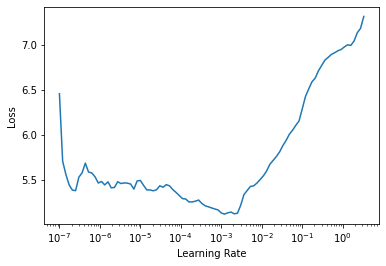

In [10]:
learn.lr_find(suggestions=True)


In [11]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(5.7477, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 119, 50265]))

In [12]:
learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,3.910198,3.462047,0.355144,0.106663,0.232398,07:02


In [13]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"[ 0086 ] fig1 illustrates the structure of a thermal head according to a first embodiment of the present invention, wherein fig1 a and 1b are a cross - sectional view and a top view thereof, respectively. this thermal head has a structure symmetrical about a center line qq ′. in fig1 reference numeral 1 denotes a stainless steel substrate having a substrate projection 2 and a radiating fin ( not shown ) for radiating heat generated by heating elements 14 and 24. the substrate projection 2 is formed integrally with the stainless steel substrate 1 so that heat is transferred from a glaze glass layer formed directly on the stainless steel substrate 1 and the substrate projection 2 to the radiating fin ( not shown ) via the substrate projection 2 and the stainless steel substrate 1. the glaze glass 3 is an insulating element serving to absorb heat remaining in the heating elements 14 and 24 and transfer the absorbed heat to the stainless steel substrate 1. the glaze glass 3 is formed on the substrate 1, for example, by coating glass paste on the substrate 1 and then baking it. in the example shown in fig1 a part of the glaze glass on the side of the heating element 14 and a part on the side of the heating element","a thermal head includes a metal substrate ; an insulating layer formed on the surface of the metal substrate ; a plurality of heating elements disposed on the surface of the insulating layer, the heating elements being arranged with a predetermined pitch along a plurality of lines in a main scanning direction, the plurality of lines being spaced apart from each other in a paper - feeding direction perpendicular to the main scanning direction ; and a heat radiating element projecting from the surface of the metal substrate to the side where the insulating layer is disposed. although most of the heat generated by the respective heating elements is transferred to an ink ribbon or print paper, residual partial heat",a thermal head consists of a glaze glass and a heating element . the heating element is formed by heating elements of the heating elements and a glazing glass . the glaze is formed from a glazed glass layer formed from glaze and a radiating fin formed from the glazing layer formed by coating the glazes with a coating of glass paste and then baking it .
1,"in accordance with embodiments of the invention, 3d metal structures may be fabricated layer - by - layer using an apparatus 100, as shown in fig1. apparatus 100 includes a mechanical gantry 105 capable of motion in one or more of five or six axes of control ( e. g., one or more of the xyz planes ) via one or more actuators 110 ( e. g., motors such as stepper motors ). as shown, apparatus 100 also includes a wire feeder 115 that positions a metal wire 120 inside the apparatus, provides an electrical connection to the metal wire 120, and continuously feeds metal wire 120 from a source 125 ( e. g., a spool ) into the apparatus. a baseplate 130 is also typically positioned inside the apparatus and provides an electrical connection ; the vertical motion of the baseplate 130 may be controlled via an actuator 135 ( e. g., a motor such as a stepper motor ). an electric power supply 140 connects to the metal wire 120 and the baseplate 130, enabling electrical connection therebetween. the motion of the gantry 105 and the motion of the wire feeder 115 are controlled by a controller 145. the application of electric current from the power supply 140, as well as the power","in various embodiments, a three - dimensional metallic structure is fabricated in layer - by - layer fashion via deposition of discrete metal particles resulting from the passing of an electric current between a metal wire and an electrically conductive base or a previously deposited layer of particles.","a apparatus for controlling the motion of a metal wire in a 3d metal structure is provided . the apparatus includes a mechanical gantry , a baseplate and a wire feeder . the g